In [1]:
import numpy as np
import sys
sys.path.insert(1,'./src/')
from models_copy import ChemicalReactionNetwork
from matplotlib import pyplot as plt
from tqdm import tqdm
import corner
from numba import jit

See [description of this notebook](./questions.md/#july-17th-non-abc)

In [2]:
species = 'A B C'.split()
reactions = [
    ({'A': 1}, {'B': 1}),
    ({'B': 1}, {'A': 1}),
    ({'B': 1}, {'C': 1}),
    ({'C': 1}, {'B': 1}),
]
kinetic_rates = [1,5e-2,5e-1,8e-1]
# some of the kinetic rates has to equal. 

model = ChemicalReactionNetwork(reactions, species, kinetic_rates)

X_init = np.array([10,20,30])

T = 30

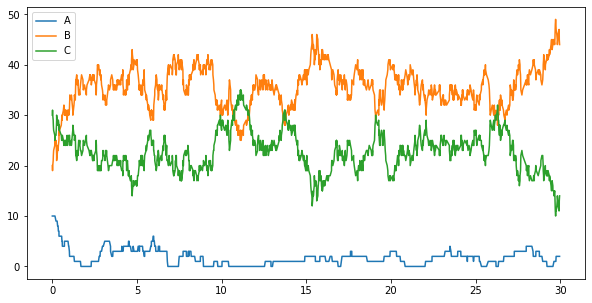

In [3]:
x,r,t = model.gilespie(X_init,T)
plt.figure(figsize=(10,5))
for i in range(3):
    plt.plot(t,x[:,i],label=species[i])
plt.legend()

the observables are only copy number of `A`, so our observation should be that:


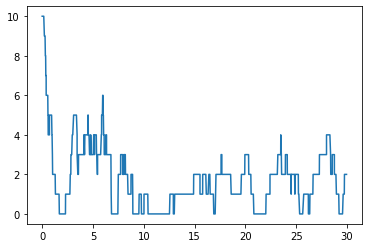

In [4]:
a = model.get_observation(t,x,'A').flatten()
plt.plot(t,a,label='observed A')

TODO : maybe I can only take observations at specific times. 

Now, let's think what's in a state:

- reaction time $t_i$
- populations of the 3 species $a_i,b_i,c_i$

So the first step is to generate an initial state based on our observation. 

The observation provides for us the $t_i,a_i$. I will use a random number generator to generate an initial guess of $b_i, c_i$


In [5]:
@jit
def get_r(a,c):
    r = np.zeros(len(a)-1,dtype=int)
    diff_a = np.diff(a,1)
    diff_c = np.diff(c,1)
    r[diff_a==-1] = 0
    r[diff_a==1] = 1
    r[diff_c==1] = 2
    r[diff_c==-1] = 3
    return r

def log_likelihood(state):
    k,a,b,c = state
    r = get_r(a,c)
    X = np.array([a,b,c]).T
    return model.gilespie_exact_log_likelihood(k,X,r,t,T)

In [6]:
total_copy_number = np.sum(x[0])

def generate_initial_state(a=a,t=t,total_copy_number=total_copy_number):
    cond = True
    while cond:
        k = np.random.uniform(1e-3,1e-1,4)
        diff_c = np.zeros(len(t)-1)
        diff_c[np.diff(a,1) == 0] = np.random.choice([-1,1],size = np.sum(np.diff(a,1) == 0))
        c0 = np.random.randint(0,total_copy_number)
        c = np.cumsum(np.insert(diff_c,0,c0))
        b = total_copy_number - a -c
        if np.any(b<0) or np.any(c<0):
            continue
        else: cond = (log_likelihood((k,a,b,c)) == -np.inf)
    initial_state = (k,a,b,c)
    return initial_state

In [7]:
initial_state = generate_initial_state()
k,a,b,c = initial_state
log_likelihood(initial_state)

/var/folders/tl/c_q79z3x4nx7f2p1700yhkcr0000gn/T/ipykernel_30375/123118156.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "get_r" failed type inference due to: No implementation of function Function(<built-in function zeros>) found for signature:
 
 >>> zeros(int64, dtype=Function(<class 'int'>))
 
There are 4 candidate implementations:
  - Of which 4 did not match due to:
  Overload in function '_OverloadWrapper._build.<locals>.ol_generated': File: numba/core/overload_glue.py: Line 131.
    With argument(s): '(int64, dtype=Function(<class 'int'>))':
   Rejected as the implementation raised a specific error:
     TypingError: Failed in nopython mode pipeline (step: nopython frontend)
   No implementation of function Function(<intrinsic stub>) found for signature:
    
    >>> stub(int64, Function(<class 'int'>))
    
   There are 2 candidate implementations:
     - Of which 2 did not match due to:
     Intrinsic of function 'st

-102.97365522717196

Text(0.5, 1.0, 'initial state')

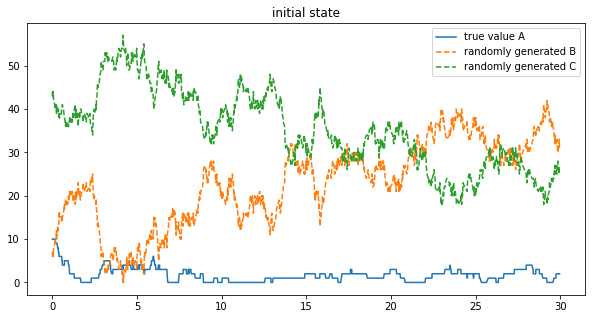

In [8]:
plt.figure(figsize=(10,5))
plt.plot(t,a,label='true value A')
plt.plot(t,b, '--',label='randomly generated B')
plt.plot(t,c, '--', label='randomly generated C')
plt.legend()
plt.title('initial state')

In this particular partial implementation, the only things we can change are 
- kinetic rates
- interchanging reactions 2 and 3. i.e. $B \xLeftrightarrow[k_4]{k_3} C$
- the initial population of the $B,C$

In [9]:
@jit
def get_box(k, box_size):

    box = []
    volume = 1

    for t in k:
        lower = max(t-box_size, 0)
        upper = t+box_size
        box.append((lower, upper))
        volume *= (upper-lower)

    box = np.array(box).T

    return box, volume

@jit
def move_k(state, box_size=1e-3):
    k, a, b, c = state
    box, volume = get_box(k, box_size)
    new_k = np.random.uniform(*box)

    _, volume2 = get_box(new_k, box_size)

    return (new_k, a, b, c), np.log(volume/volume2)

@jit
def move_reaction(state):
    _, a, b, c = state
    r = get_r(a, c)

    cond = True
    while cond:
        choice = np.concatenate((np.where(r == 2)[0], np.where(r == 3)[0]))
        dr_index = np.random.choice(choice, 1)
        dr_v = r[dr_index]
        if dr_v == 2:
            r[dr_index] = 3
        if dr_v == 3:
            r[dr_index] = 2
        diff_c = np.zeros(len(r))
        diff_c[r == 2] = 1
        diff_c[r == 3] = -1
        new_c = np.cumsum(np.insert(diff_c, 0, c[0]))

        new_b = total_copy_number - a - new_c
        if np.all(new_b >= 0) and np.all(new_c >= 0):
            cond = False
        else:
            r[dr_index] = dr_v

    return (_, a, new_b, new_c), 0
    # returning 0 as the log_probability is not exact. But to compute the exact one would take many computing time.

@jit
def move_initial_copynumber(state):
    _, a, b, c = state
    if min(b) == 0 and min(c) == 0:
        return "Not going to move", 0
    if min(b) == 0:
        b += 1
        c -= 1
        log_p = np.log(1/2)
    if min(c) == 0:
        c += 1
        b -= 1
        log_p = np.log(1/2)
    else:
        if np.random.randint(0, 2) == 0:
            b += 1
            c -= 1
        else:
            b -= 1
            c += 1
        log_p = 0
    return (_, a, b, c), log_p


moves = [move_k, move_reaction, move_initial_copynumber]


def move(state):
    move = moves[np.random.randint(0, len(moves))]
    newstate, log_p = move(state)
    if newstate == "Not going to move":
        move = moves[np.random.randint(0, len(moves)-1)]
        newstate, log_p = move(state)
    return newstate, log_p

@jit
def mcmc(initial_state, n):

    samples = [initial_state]
    if_accepted = []

    prev_log_pst = log_likelihood(initial_state)

    for i in tqdm(range(n), desc='sampling state space'):

        new_state, log_p = move(samples[-1])
        curr_log_pst = log_likelihood(new_state)
        log_acceptance = curr_log_pst - prev_log_pst + log_p
        if_accepted.append(log_acceptance >= 0 or np.log(
            np.random.uniform()) < log_acceptance)
        if if_accepted[-1]:
            samples.append(new_state)
            prev_log_pst = curr_log_pst
        else:
            samples.append(samples[-1])
    
    print('acceptance rate:', np.mean(if_accepted))
    return samples

In [10]:
pst_samples = mcmc(initial_state, n=50000)

/var/folders/tl/c_q79z3x4nx7f2p1700yhkcr0000gn/T/ipykernel_30375/1395046736.py:90: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "mcmc" failed type inference due to: Untyped global name 'log_likelihood': Cannot determine Numba type of <class 'function'>

File "../../../var/folders/tl/c_q79z3x4nx7f2p1700yhkcr0000gn/T/ipykernel_30375/1395046736.py", line 96:
<source missing, REPL/exec in use?>

  @jit
/var/folders/tl/c_q79z3x4nx7f2p1700yhkcr0000gn/T/ipykernel_30375/1395046736.py:90: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "mcmc" failed type inference due to: Untyped global name 'log_likelihood': Cannot determine Numba type of <class 'function'>

File "../../../var/folders/tl/c_q79z3x4nx7f2p1700yhkcr0000gn/T/ipykernel_30375/1395046736.py", line 96:
<source missing, REPL/exec in use?>

  @jit
/opt/homebrew/Caskroom/miniforge/base/envs/mcmc/lib/python3.10/site-packages/numba/

: 

: 

In [ ]:
pst_k = np.array([s[0] for s in pst_samples])

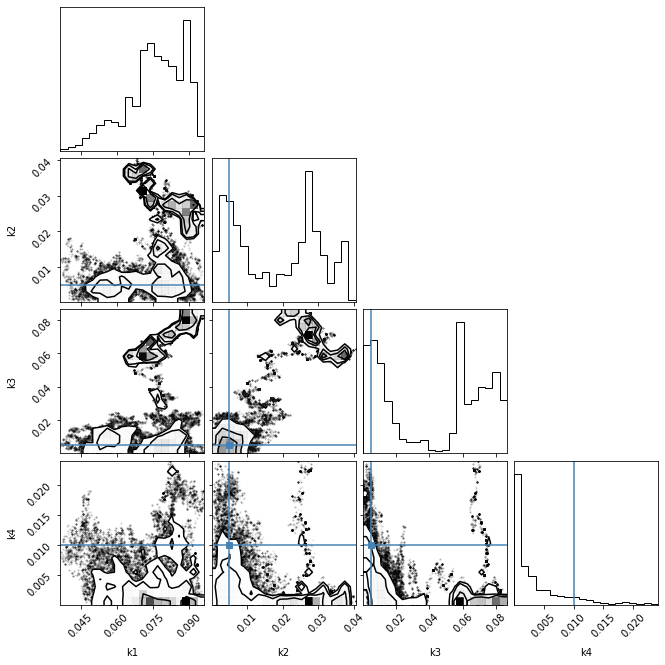

In [ ]:
corner.corner(pst_k[10000:], labels=['k1', 'k2', 'k3', 'k4'], truths=kinetic_rates)
print()

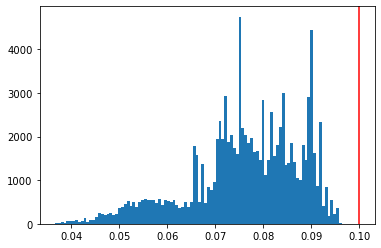

In [ ]:
plt.hist( pst_k[:,0], bins = 100)
plt.axvline(kinetic_rates[0],c='r')
print()


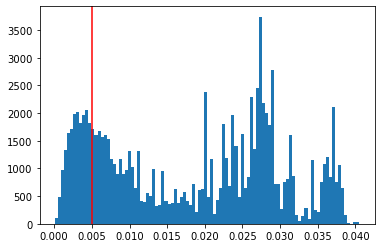

In [ ]:
plt.hist( pst_k[:,1], bins = 100)
plt.axvline(kinetic_rates[1],c='r')
print()


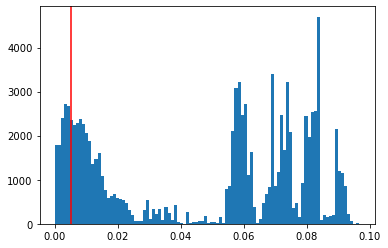

In [ ]:
plt.hist(pst_k[:,2], bins = 100)
plt.axvline(kinetic_rates[2],c='r')

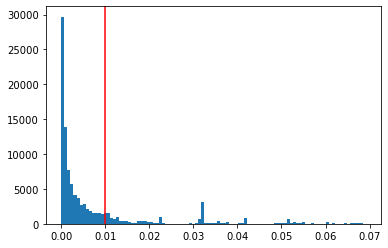

In [ ]:
plt.hist(pst_k[:,3], bins = 100)
plt.axvline(kinetic_rates[3],c='r')

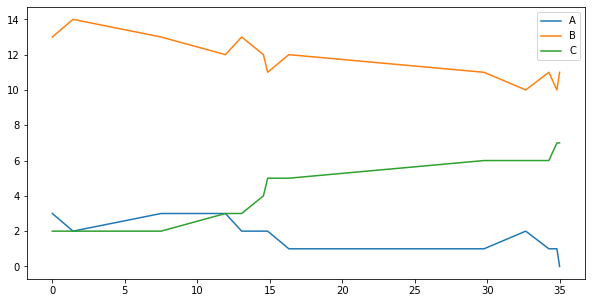

In [ ]:
plt.figure(figsize=(10,5))
for i in range(3):
    plt.plot(t,pst_samples[-1][i+1],label=species[i])
plt.legend()

In [ ]:
np.linalg.norm((np.array(initial_state[1:]).T - x).flatten())

28.142494558940577

In [ ]:
distance = [np.linalg.norm((np.array(pst_samples[i][1:]).T - x).flatten()) for i in range(1000,len(pst_samples))]
log_likelihoods = [log_likelihood(pst_samples[i]) for i in range(1000,len(pst_samples))]

In [ ]:
distance = np.array(distance)
np.where(distance == 0.0)

(array([63437, 63438, 63439, 76370, 76371, 76372, 76373, 76374, 76375,
        76376, 79279, 79280, 79281, 79282, 79283, 79284, 79285, 88334,
        88335, 88336, 88337, 91271, 96210, 96211, 96212, 96213, 97881]),)

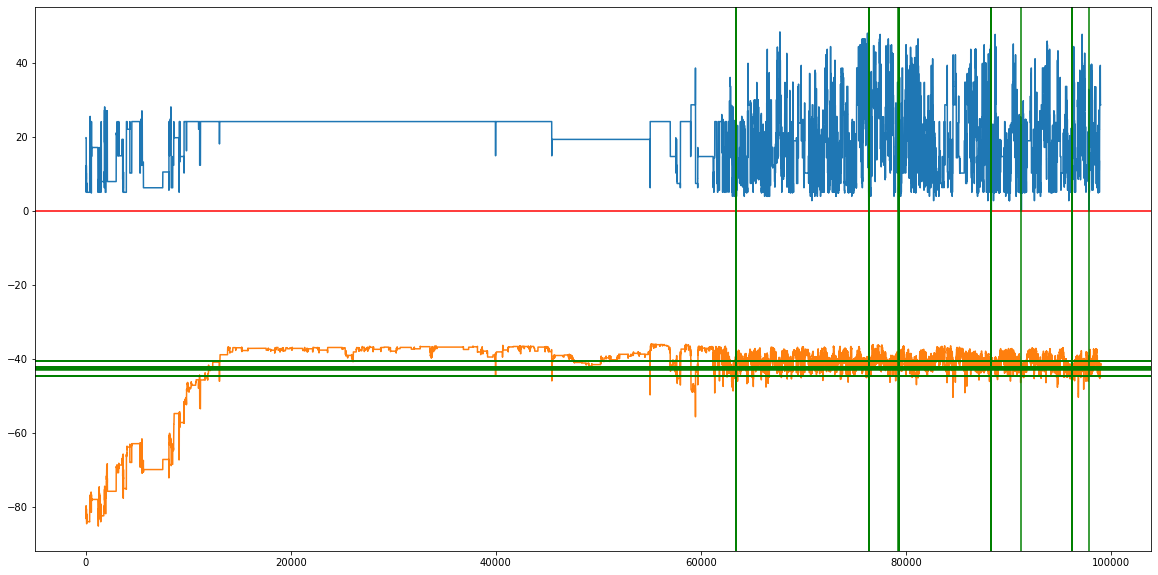

In [ ]:

plt.figure(figsize=(20,10))
plt.plot(distance)
plt.axhline(0,c='r')
plt.plot(log_likelihoods)
for i in np.where(distance == 0)[0]:
    plt.axvline(i,c='g')
    plt.axhline(log_likelihoods[i],c='g')